<a href="https://colab.research.google.com/github/amyush/FrequencyDomain_Watermarking/blob/main/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up the environment**

In [32]:
# Cloning the github repository
!git clone https://github.com/amyush/FrequencyDomain_Watermarking.git

fatal: destination path 'FrequencyDomain_Watermarking' already exists and is not an empty directory.


In [33]:
# Importing libraries
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from PIL import Image as im
import math
from scipy.fftpack import dct
from scipy.fftpack import idct
from google.colab.patches import cv2_imshow

# **Custom Functions**

In [34]:
def setParams():
    global alpha 
    alpha = 0.02
    global betaFactor
    betaFactor = 1
    global imgPath
    imgPath = "FrequencyDomain_Watermarking/"
    global factor
    factor = 8

def stringToBinary(a):
  l=[]
  res = ''.join(format(ord(i), '08b') for i in a)
  return res

def calculatePSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                    # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def apply_dct(image_array):
    # size = (int)(math.sqrt(image_array.size))
    size = len(image_array[0])
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    size = len(all_subdct[0])
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct
    return all_subidct


# **Steganography**

## **Hiding the data**

In [35]:
def encodingImage(imageName, key, hiddenImageName):
    # Setting the global parameters
    setParams();

    # Coverting the key to its binary representation
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)

    # Reading the cover image
    originalImage = cv2.imread(imgPath + imageName)

    # Setting the size of the carrier image to 512
    sizeOrig = 512
    # Resizing the carrier image
    originalImage = cv2.resize(originalImage, (sizeOrig, sizeOrig))

    # Reading the watermark image
    waterMarkLogo = cv2.imread(imgPath + hiddenImageName)
    # Setting the size of the watermark image as 64
    sizeWatermark = 64
    # Resizing the watermark logo
    waterMarkLogo = cv2.resize(waterMarkLogo, (sizeWatermark, sizeWatermark))
    
    # Converting the pixel value of watermark to float
    waterMarkArray = np.array(waterMarkLogo,dtype=float)

    flatWaterMarkArray = np.zeros(shape = (sizeWatermark,sizeWatermark,3))
    # Applying DCT to each channel in the carrier image
    flatWaterMarkArray[:,:,0] = apply_dct(waterMarkArray[:,:,0])
    flatWaterMarkArray[:,:,1] = apply_dct(waterMarkArray[:,:,1])
    flatWaterMarkArray[:,:,2] = apply_dct(waterMarkArray[:,:,2])

    # Creating the output array of appropiate size with values 0    
    waterMarkedImage = np.zeros((sizeOrig,sizeOrig,3))

    # Inserting the watermark image in the carrier image
    # For each channel 0, 1 and 2
    for dim in range(0,3,1):
        inputArray = np.array(originalImage[:,:,dim], dtype=float)
        # Converting 1 channel of the watermark image into 1D array
        flatWaterMark = (flatWaterMarkArray[:,:,dim]/255).ravel()

        index = -1
        count = 0
        beta = betaFactor

        # Traversing image in 8 by 8 block-wise
        for i in range(0, sizeOrig, 8):
            for j in range(0, sizeOrig, 8):
                index += 1
                # If the current index of key (binary) is 1 - multiplying beta with -1
                if((int)(binKey[index%lenBinKey]) == 1):
                    beta *= -1
                # Calculating the DCT coefficient of the 8 by 8 block of the carrier image
                inputArray[i:i+8,j:j+8]=dct(dct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                # Applying the formula according to the formula 
                inputArray[i+1][j+1] += alpha * beta * flatWaterMark[count]
                # Calculating the inverse dct on the 8 by 8 block
                inputArray[i:i+8,j:j+8]=idct(idct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                count += 1

        # Storing the updated values in the output array for the current channel
        waterMarkedImage[:,:,dim] = inputArray

    # Writing the watermarked image in the local storage
    res = cv2.imwrite('waterMarkedImage.jpg', waterMarkedImage)
    return originalImage, waterMarkedImage, waterMarkLogo, sizeWatermark


## **Extracting the watermark image**

In [36]:
def extractImage(imageName, waterMarkedImage, key):
    # Setting the global parameters
    setParams();
    
    # Coverting the key to its binary representation
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)

    # Setting the size of the carrier image according to the watermarked image
    sizeOrig = waterMarkedImage.shape[0]

    # Size of the watermark logo which will be exracted
    size = sizeOrig // 8

    # Reading the original carrier image
    originalImage = cv2.imread(imgPath + imageName)
    # Resizing the image to same size as watermarked image
    originalImage = cv2.resize(originalImage, (sizeOrig, sizeOrig))
    # Creating the output array of the appropiate dimension
    logo = np.zeros(shape = (size,size,3))

    # Looping over the watermarked image
    # For each channel 0, 1 and 2
    for dim in range(0,3,1):
        inputArray = np.array(originalImage[:,:,dim], dtype=float)
        # Taking 1 channel of the watermark image at a time
        watermarkArray = waterMarkedImage[:,:,dim]

        ext_wm=[]
        k=0
        z=0
        beta = betaFactor
        index = -1
        
        # Traversing image in 8 by 8 block-wise
        for i in range(0,sizeOrig,8):
            for j in range(0,sizeOrig,8):
                index += 1
                # If the current index of key (binary) is 1 - multiplying beta with -1
                if((int)(binKey[index%lenBinKey]) == 1):
                    beta *= -1

                # Calculating the DCT coefficient of the 8 by 8 block - in original image
                subOrignal = dct(dct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                # Calculating the DCT coefficient of the 8 by 8 block - in carrier image
                subWaterMarked = dct(dct(watermarkArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                # calculating the value of the logo accoridng to the paper
                val= (beta * (subWaterMarked[1][1] - subOrignal[1][1])) / alpha
                # Appending the value to the output array
                ext_wm.append(val)
        
        # Converting the flat array to the size by size
        ext_wm = np.array(ext_wm,dtype=float).reshape((size,size))
        # Applying the inverse DCT on the 8 by 8 block
        logo[:,:,dim] = inverse_dct(ext_wm)

    # Multiplying each pixel value with 255
    logo = logo * 255
    # Converting the values to uint8 from float
    logo = logo.astype(np.uint8)

    cv2_imshow(logo)
    return logo

# **Attacks**

In [37]:
def attackGauss(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5

    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisyImage = image + gauss
    return noisyImage

def attackSNP(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.01
    sNpImage = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    sNpImage[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    sNpImage[coords] = 0
    return sNpImage


def attackPoisson(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
    
def attackSpeckle(image):
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

def attackRotate90(image):
    angle = 90
    scale = 1.0
    w = image.shape[1]
    h = image.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
    nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
    rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
    rot_move = np.dot(rot_mat, np.array(
        [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]
    noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
    return noisy


# **Results**

Enter the cover filename: (eg- cover.jpg or lena.png)cover.jpg
Enter the key:Appppa
Enter the name of the image to be hidden: (eg- iitbbs_logo.jpeg or logo.png)logo.png


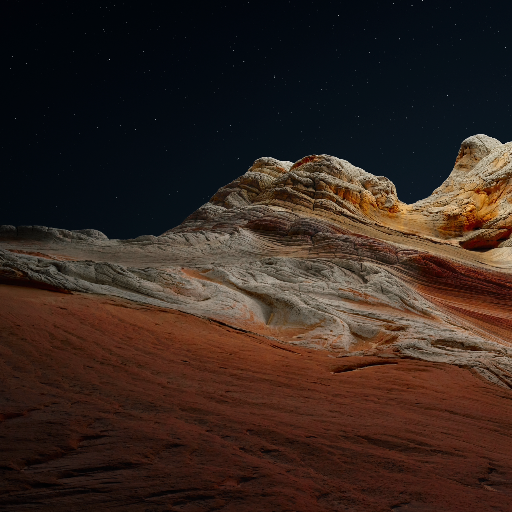

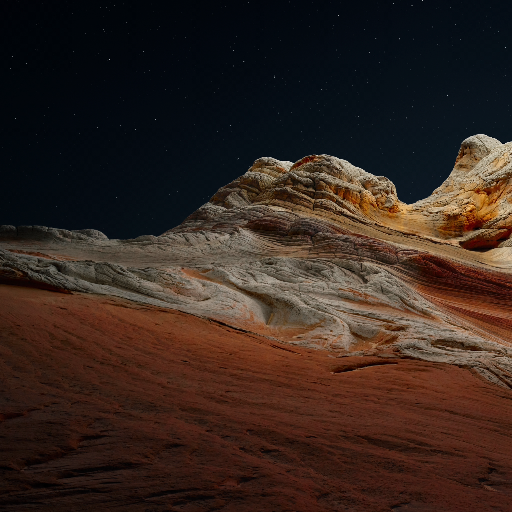

In [38]:
coverFileName = input("Enter the cover filename: (eg- cover.jpg or lena.png)")
key = input("Enter the key:")
hiddenImageName = input("Enter the name of the image to be hidden: (eg- iitbbs_logo.jpeg or logo.png)")

originalImage, waterMarkedImage, waterMarkLogo, size = encodingImage(coverFileName, key, hiddenImageName)
psnr = calculatePSNR(waterMarkedImage, originalImage)

cv2_imshow(originalImage)
cv2_imshow(waterMarkedImage)

PSNR value = 102.87995799138366


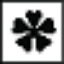

NC value of the extracted logo = [[0.99999535]]


In [41]:
print('PSNR value = {}'.format(psnr))
extractedLogo = extractImage(coverFileName, waterMarkedImage, key)
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


PSNR value after gaussian attack is:  68.13535955807868
PSNR value after salt-N-pepper attack is:  34.57646522171676
PSNR value after speckle attack is:  12.876945716539222
PSNR value after rotate90 attack is:  13.582353250192575
Gaussian Attack Results :


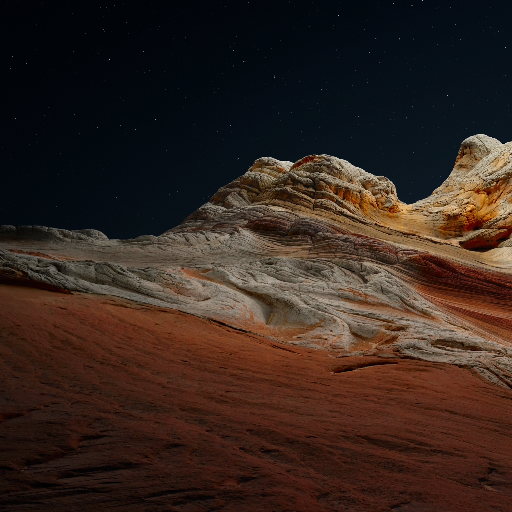

Salt-N-Pepper Attack Results :


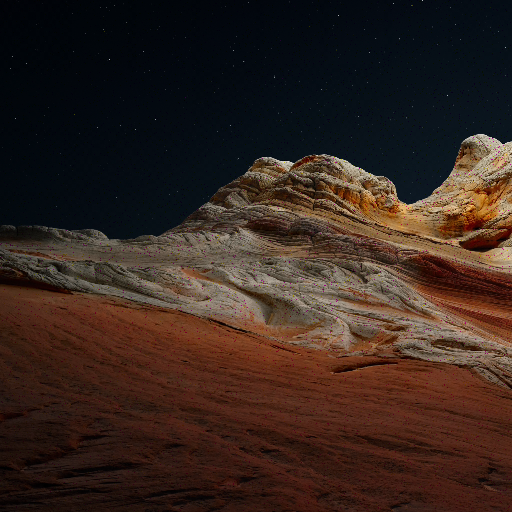

Speckle Attack Results :


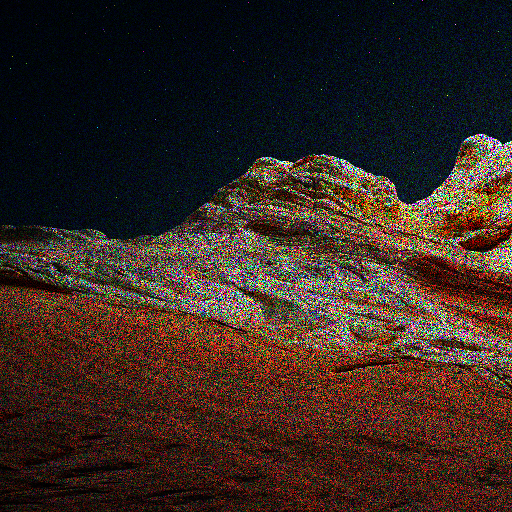

Rotate-90 Attack Results :


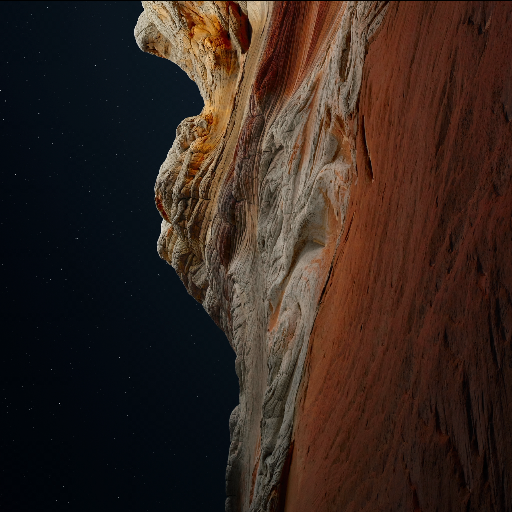

In [42]:
# Implementing gaussian attack
gaussNoiseImage = attackGauss(waterMarkedImage)
# Implementing salt-N-pepper attack
sNpNoiseImage = attackSNP(waterMarkedImage)
# Implementing speckle attack
speckleNoiseImage = attackSpeckle(waterMarkedImage)
# Implementing rotate-90 attack
rotate90Image = attackRotate90(waterMarkedImage)

# Calculating the PSNR of the original image and the attacked watermarked image
gaussNoisePSNR = calculatePSNR(originalImage, gaussNoiseImage)
sNpNoisePSNR = calculatePSNR(originalImage, sNpNoiseImage)
specklePSNR = calculatePSNR(originalImage, speckleNoiseImage)
rotate90PSNR = calculatePSNR(originalImage, rotate90Image)

print("PSNR value after gaussian attack is: ", gaussNoisePSNR)
print("PSNR value after salt-N-pepper attack is: ", sNpNoisePSNR)
print("PSNR value after speckle attack is: ", specklePSNR)
print("PSNR value after rotate90 attack is: ", rotate90PSNR)

print("Gaussian Attack Results :")
cv2_imshow(gaussNoiseImage)    
print("Salt-N-Pepper Attack Results :")
cv2_imshow(sNpNoiseImage)
print("Speckle Attack Results :")
cv2_imshow(speckleNoiseImage)    
print("Rotate-90 Attack Results :")
cv2_imshow(rotate90Image)


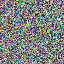

NC value of the extracted logo = [[0.73158026]]


In [47]:
# Extracting the logo from the gaussian attacked image
extractedLogo = extractImage(coverFileName, gaussNoiseImage, key)
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))

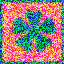

NC value of the extracted logo = [[0.82908624]]


In [48]:
# Extracting the logo from the salt-n-pepper attacked image
extractedLogo = extractImage(coverFileName, sNpNoiseImage, key)
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))

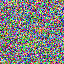

NC value of the extracted logo = [[0.7263628]]


In [49]:
# Extracting the logo from the speckle attacked image
extractedLogo = extractImage(coverFileName, speckleNoiseImage, key)
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))

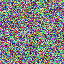

NC value of the extracted logo = [[0.72558564]]


In [50]:
# Extracting the logo from the rotate-90 attacked image
extractedLogo = extractImage(coverFileName, rotate90Image, key)
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))